<a href="https://colab.research.google.com/github/jeniferwerthman/AdvAILSTM/blob/main/LSTMStock_FinalVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import pandas as pd
import pandas_datareader as pdr
import os
import matplotlib.pyplot as mplot
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import numpy as np
import altair as alt 
import tensorflow as tf 
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [116]:
#Import Data
stockDf = pd.read_csv('MSFT.csv',delimiter=',')
stockDf['openChange'] = stockDf.Open.pct_change()
stockDf['closeChange'] = stockDf.Close.pct_change()
stockDf['weekday_num'] = pd.DatetimeIndex(stockDf['Date']).weekday
stockDf['month'] = pd.DatetimeIndex(stockDf['Date']).month
stockDf['day'] = pd.DatetimeIndex(stockDf['Date']).day
stockDf['year'] = pd.DatetimeIndex(stockDf['Date']).year
stockDf['display'] = stockDf["month"].map(str)+ "-" + stockDf["year"].map(str)

# Select features (columns) to be involved intro training and predictions
cols = list(stockDf)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(stockDf['Date']) 
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(stockDf.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (1260, 14)
All timestamps == 1260
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close']


In [98]:
[[stockDf]]

[[            Date        Open        High         Low       Close   Adj Close  \
  0     2017-04-17   65.040001   65.489998   65.010002   65.480003   61.124588   
  1     2017-04-18   65.330002   65.709999   65.160004   65.389999   61.040569   
  2     2017-04-19   65.650002   65.750000   64.889999   65.040001   60.713860   
  3     2017-04-20   65.459999   65.750000   65.139999   65.500000   61.143257   
  4     2017-04-21   65.669998   66.699997   65.449997   66.400002   61.983387   
  ...          ...         ...         ...         ...         ...         ...   
  1255  2022-04-08  300.440002  301.119995  296.279999  296.970001  296.970001   
  1256  2022-04-11  291.790009  292.609985  285.000000  285.260010  285.260010   
  1257  2022-04-12  289.239990  290.739990  280.489990  282.059998  282.059998   
  1258  2022-04-13  282.730011  288.579987  281.299988  287.619995  287.619995   
  1259  2022-04-14  288.089996  288.309998  279.320007  279.829987  279.829987   
  
          Vol

In [ ]:
(alt.Chart(stockDf).mark_line().encode(x='Date', y='Close').properties(height=400, width=500))

In [ ]:
stockDf.Date = pd.to_datetime(stockDf.Date, format = '%Y/%m/%d')
plot_Stock = stockDf.set_index('Date') 
plot_Stock['Close'].plot(figsize=(10,5))

In [ ]:
closedChart = (alt.Chart(stockDf).mark_line().encode(x='Date', y='closeChange', color=alt.value('black')).properties(height=400, width=2000))
openChart = (alt.Chart(stockDf).mark_line().encode(x='Date', y='openChange', color=alt.value('green')).properties(height=400, width=2000))
closedChart+openChart

In [ ]:
open = (alt.
         Chart(stockDf).
         mark_line().
         encode(x=alt.X('display', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=400, width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.year==2018).
         mark_line().
         encode(x=alt.X('display', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=200, width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.year==2018).
         mark_line().
         encode(x=alt.X('week(Date):T', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=200  , width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).
         mark_line().
         encode(x=alt.X('month(Date):T'), y='max(closeChange)', color='year').
         properties(height=200  , width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.month==3).
         mark_line().
         encode(x=alt.X('day', sort=['year', 'month']), y='max(Volume)', color='year').
         properties(height=200  , width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.month==3).
         mark_line().
         encode(x=alt.X('day', sort=['year', 'month']), y='max(closeChange)', color='year').
         properties(height=200  , width=500))
open

In [124]:
#Creating a new Dataframe & Dataset with subset of records 

#Parameters
limitList = False
fromRecord = 50
toRecord = 100

newDf = pd.DataFrame().assign(Open=stockDf['Open'], Close=stockDf['Close'], Volume=stockDf['Volume'])
if limitList:
  newDf = newDf.loc[fromRecord:toRecord]
myDs = newDf.values
myDs = myDs.astype('float32')
newDf.head(5)

,Open,Close,Volume
0,65.040001,65.480003,16689300
1,65.330002,65.389999,15155600
2,65.650002,65.040001,26992800
3,65.459999,65.500000,22299500
4,65.669998,66.400002,32522600


In [129]:
#Normalizing Data

#Parameters
trainingSet = .70
featureRange1 = 0
featureRange2 = 1
newShape1 = -1
newShape2 = 1 

myDs = np.reshape(myDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
myDs = scaler.fit_transform(myDs)
trainingSize = int(len(myDs) * trainingSet)
testingSize = int(len(myDs) - trainingSize)
trainData, testData = myDs[0:trainingSize,:], myDs[testingSize:len(myDs),:]

In [130]:
#Parameters
batchSize = 5
timeSteps = 1
#Batch Data for optimization and accuracy
#This creates batches with 1 to N records.  
#X - Each Batch starts with the next item i in the list and contains specified number of additional items
#Y - Contains the last item in each batch "L" or first "F" or previious "P" or next "N"
def batchData(data, size, indexAlignment = "L"):
    X, Y = [], [] 
    for i in range(len(data) - size - 1): 
        X.append(data[i:(i + size), 0])
         
        if indexAlignment == "N":
          Y.append(data[i + size, 0])
        elif indexAlignment == "L":
          Y.append(data[i + size - 1, 0])
        elif indexAlignment == "P":  
          Y.append(data[i-1, 0])
        else:
          Y.append(data[i, 0]) 

    return np.array(X), np.array(Y)

#Catch Batches for Accuracy and Optimization
X_train, Y_train = batchData(trainData, batchSize, "L")
X_test, Y_test = batchData(testData, batchSize,"L")

In [131]:
#Reshape data to normalize it [samples, time steps, features]
print("take 1")
print('X_Train[0] (Samples): ' + str(X_train.shape[0]))
print('X_Train[1] (Features): ' + str(X_train.shape[1]))
X_train = np.reshape(X_train, (X_train.shape[0], timeSteps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], timeSteps, X_test.shape[1]))
print("take 2")
print('X_Train[0] (Samples): ' + str(X_train.shape[0]))
print('X_Train[1] (Features): ' + str(X_train.shape[1]))

take 2
X_Train[0] (Samples): 2640
X_Train[1] (Features): 5
take 2
X_Train[0] (Samples): 2640
X_Train[1] (Features): 1


In [132]:
#Parameters
verboseAmt = 1
epochCnt = 25
shuffleData = False
dropOut = 0.2
lstmActivation = 'relu'
activationLayer = 'linear'
lossType = 'mean_squared_error'
optimizerType = 'adam'
lstmUnits = 50
lstmMultipleLayers = True

model = Sequential()

if lstmMultipleLayers:
  model.add(LSTM(units = lstmUnits, return_sequences = True, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize)))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits))
  model.add(Dropout(dropOut))
else:
  model.add(LSTM(units = lstmUnits, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize))) 
  model.add(Dropout(dropOut))

model.add(Dense(1, activation = activationLayer))
model.compile(loss = lossType, optimizer = optimizerType)
modelFit = model.fit(X_train, Y_train, epochs = epochCnt, batch_size = batchSize, validation_data = (X_test, Y_test), verbose = verboseAmt, shuffle = False)
model.summary()

Epoch 1/100
528/528 [==============================] - 14s 14ms/step - loss: 0.0039 - val_loss: 7.1218e-04
Epoch 2/100
528/528 [==============================] - 5s 9ms/step - loss: 0.0013 - val_loss: 6.9415e-04
Epoch 3/100
528/528 [==============================] - 5s 9ms/step - loss: 0.0011 - val_loss: 3.3105e-04
Epoch 4/100
528/528 [==============================] - 5s 9ms/step - loss: 9.1537e-04 - val_loss: 7.4239e-05
Epoch 5/100
528/528 [==============================] - 5s 9ms/step - loss: 8.1940e-04 - val_loss: 2.1520e-04
Epoch 6/100
528/528 [==============================] - 5s 9ms/step - loss: 0.0010 - val_loss: 3.5741e-04
Epoch 7/100
528/528 [==============================] - 5s 9ms/step - loss: 8.3907e-04 - val_loss: 2.1920e-04
Epoch 8/100
528/528 [==============================] - 5s 9ms/step - loss: 8.6153e-04 - val_loss: 1.5039e-04
Epoch 9/100
528/528 [==============================] - 5s 9ms/step - loss: 7.2413e-04 - val_loss: 8.6760e-05
Epoch 10/100
528/528 [===========

KeyboardInterrupt: ignored

In [133]:
#Predictions
train_predict = model.predict(X_train)
Y_trained_predict = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)
Y_test_predict = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [142]:
print('X_train: ' + str(len(X_train)))
print('X_test: ' + str(len(X_test)))
print('Y_train: ' + str(len(Y_train)))
print('Y_test: ' + str(len(Y_test)))
print('')
print('train_predict: ' + str(len(train_predict)))
print('Y_trained_predict: ' + str(len(Y_trained_predict)))
print('test_predict: ' + str(len(test_predict)))
print('Y_test_predict: ' + str(len(Y_test_predict)))
print('Shape of Y_train:' ) + Y_train.shape[0]
print('Shape of Y_train:' ) + Y_train.shape[0]
print('Shape of Y_train:' ) + Y_train.shape[0]
print('Shape of Y_train:' ) + Y_train.shape[0] 

X_train: 2640
X_test: 2640
Y_train: 1
Y_test: 1

train_predict: 2640
Y_hat_train: 2640
test_predict: 2640
Y_hat_test: 2640


In [139]:
#inverse the inverse
Y_trained_predict = scaler.inverse_transform(train_predict)
Y_test_predict = scaler.inverse_transform(test_predict)

s1 = Y_test.shape[0]
s2 = Y_test.shape[1]
Y_test = Y_test.reshape(s2,s1)
s1 = Y_train.shape[0]
s2 = Y_train.shape[1]
Y_train = Y_train.reshape(s2,s1)

In [138]:
#Calculate Accuracy
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_trained_predict))
test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_predict))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

ValueError: ignored

In [136]:
#Actual vs Predicted Data
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_trained_predict, Y_test_predict)

result_df = pd.DataFrame()
result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
result_df.head()

,Actual_Y,Predicted_Y
0,3.146283e-09,0.000049
1,1.362393e-01,0.127224
2,5.483571e-09,-0.000031
3,0.000000e+00,-0.000028
4,2.426487e-01,0.227874


Text(0, 0.5, 'Value of Stock')

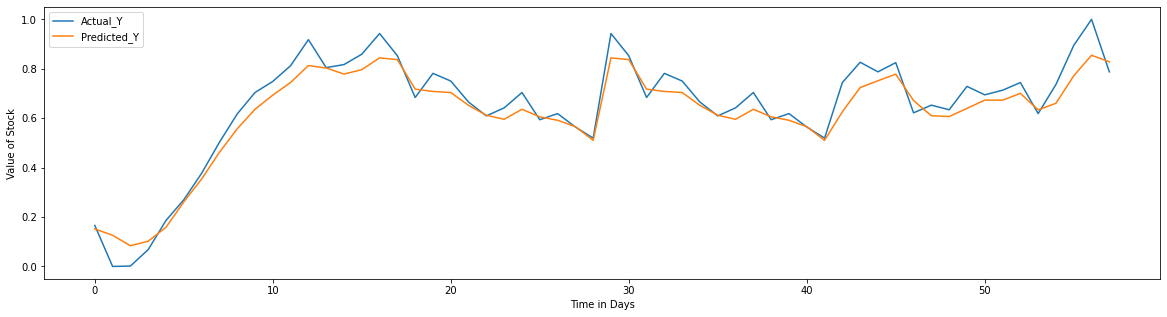

In [114]:
#Actual vs Predicted Graph
result_df.plot(figsize=(20,5))
mplot.xlabel('Time in Days')
mplot.ylabel('Value of Stock')